In [1]:
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

>
Loading device for training

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
batch_size = 128

>
Initializing the transsforms for the images

In [4]:
# Load and preprocess the dataset
transform = transforms.Compose(
            [transforms.Resize((150,150)), # Resize images to 150x150 pixels
            transforms.ToTensor(), # Convert images to tensors
            transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))]) # Normalize images

In [5]:
trainset = torchvision.datasets.ImageFolder(root='./Dataset/seg_train', transform=transform)
testset = torchvision.datasets.ImageFolder(root='./Dataset/seg_test', transform=transform)

>
Setting 10 percent of Training data as validatioN

In [6]:
size_valid = 0.10

number_train = len(trainset)
indx = list(range(number_train))

np.random.shuffle(indx)
split = int(size_valid * number_train)

train_idx, valid_idx = indx[split:], indx[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [8]:
print(f'Train data : {trainset}\n\n\nTest data : {testset}')

Train data : Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ./Dataset/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.425, 0.415, 0.405), std=(0.205, 0.205, 0.205))
           )


Test data : Dataset ImageFolder
    Number of datapoints: 3000
    Root location: ./Dataset/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.425, 0.415, 0.405), std=(0.205, 0.205, 0.205))
           )


# Model Finetuning (ResNet 50)

In [9]:
# Load ResNet
resnet = models.wide_resnet50_2(weights=True)

number_feature = resnet.fc.in_features
resnet.fc = nn.Linear(in_features=number_feature , out_features=6)

/usr/lib/python3/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
resnet = resnet.to(device)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [11]:
learning_rate = 0.01
num_epochs = 5

In [12]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[3,6], gamma=0.055)

Epoch [1/5], Step [1/99], Loss: 1.8362910747528076, Accuracy: 13.28125
Epoch [2/5], Step [1/99], Loss: 1.3342407941818237, Accuracy: 43.75
Epoch [3/5], Step [1/99], Loss: 0.8952857851982117, Accuracy: 68.75
Epoch [4/5], Step [1/99], Loss: 0.9247267246246338, Accuracy: 60.15625
Epoch [5/5], Step [1/99], Loss: 0.6929360628128052, Accuracy: 67.96875
Finished Training
Train Accuracy:  56.766098484848484
Train Loss:  1.093149611624804
Sublpots of Train Accuracy and Train Loss


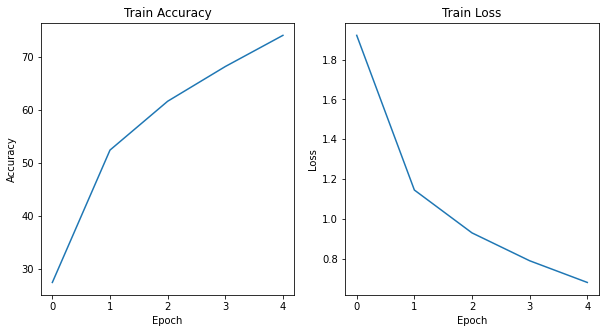

In [13]:
#train
resnet.train()

# Train the model
Train_Accuracy = []
Train_Loss = []
for epoch in range(num_epochs):
    running_loss = []
    running_acc = []
    val_loss = 0.0
    val_acc = 0.0
    # Loop over the training batches
    for i, data in enumerate(trainloader):
        # Get the inputs and the labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = resnet(inputs).to(device)
        # Compute the loss and the accuracy
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, 1)
        acc = torch.sum(preds == labels) / batch_size
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss.append(loss.item())
        running_acc.append(acc.item())
        if i % 150 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(trainloader)}], Loss: {np.mean(running_loss)}, Accuracy: {np.mean(running_acc)*100}')
    Train_Accuracy.append(np.mean(running_acc)*100)
    Train_Loss.append(np.mean(running_loss))

print('Finished Training')
print('Train Accuracy: ', np.mean(Train_Accuracy))
print('Train Loss: ', np.mean(Train_Loss))

print('Sublpots of Train Accuracy and Train Loss')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(Train_Accuracy)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(Train_Loss)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Step: [1/11], Loss: 0.7015286684036255, Accuracy: 71.875
Finished Validation
Validation Accuracy:  73.7215909090909
Validation Loss:  0.6809618202122775
Subplots of Validation Accuracy and Validation Loss


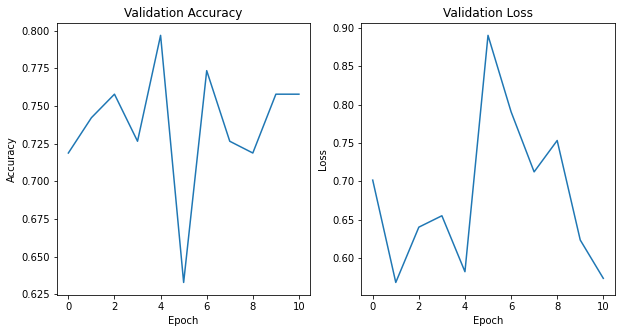

In [14]:
# Loop over the validation batches
with torch.no_grad():
    val_loss = []
    val_acc = []
    # Set the model to evaluation mode
    resnet.eval()
    for i,data in enumerate(validloader):
        # Get the inputs and the labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = resnet(inputs)
        # Compute the loss and the accuracy
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = torch.sum(preds == labels) / batch_size
        # Print statistics
        val_loss.append(loss.item())
        val_acc.append(acc.item())
        if i % 35 == 0:
            print(f'Step: [{i + 1}/{len(validloader)}], Loss: {np.mean(val_loss)}, Accuracy: {np.mean(val_acc)*100}')

print('Finished Validation')
print('Validation Accuracy: ', np.mean(val_acc)*100)
print('Validation Loss: ', np.mean(val_loss))

print('Subplots of Validation Accuracy and Validation Loss')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(val_acc)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
plt.plot(val_loss)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

>
# Making Predictions and Displaying

In [15]:
idx_to_class = {0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [16]:
def Show_Prediction(image, pred, actual):
    plt.figure(figsize=(6,6))
    plt.imshow(image.cpu().permute(1,2,0))
    plt.title(f'Actual: {idx_to_class[actual.item()]}, Prediction: {idx_to_class[pred.item()]}')
    plt.show()

In [19]:
#Inverse transform for the images to be displayed
inv_transform = transforms.Compose([transforms.Normalize(mean=[-0.425/0.205, -0.415/0.205, -0.405/0.205], std=[1/0.205, 1/0.205, 1/0.205])])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


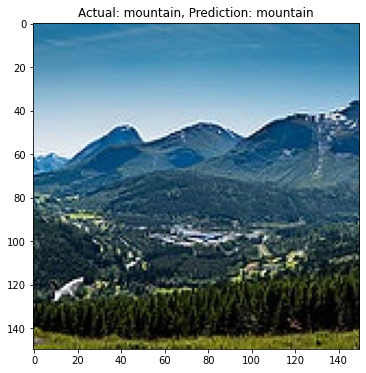

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


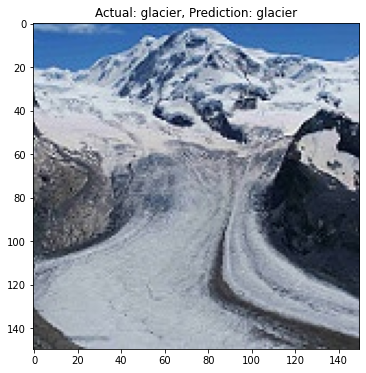

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


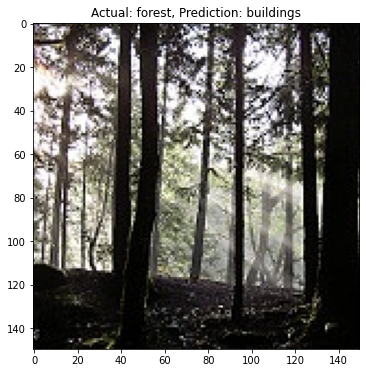

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


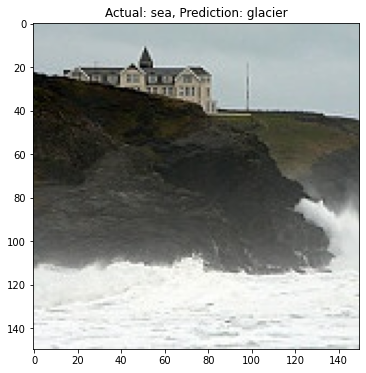

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


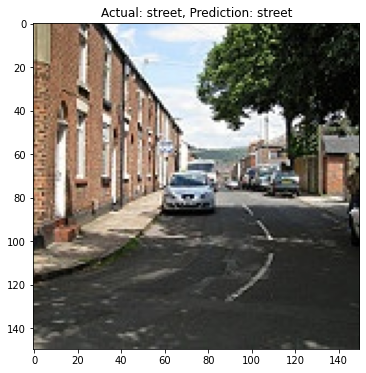

Test Accuracy of the network on the test images: 72.300 %


In [21]:
# Evaluate the model on the testing set
correct = 0
total = 0

# Loop over the testing batches
with torch.no_grad():
    for i,data in enumerate(testloader):
        # Get the inputs and the labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = resnet(inputs)

        # Compute the loss and the accuracy
        preds = torch.argmax(outputs, dim=1)

        if i % 5 == 0: 
            if np.shape(inputs)[0] == 1:
                image = inv_transform(inputs)
                Show_Prediction(image, preds, labels)
            else:
                image = inv_transform(inputs[0])
                Show_Prediction(image, preds[0], labels[0])

        # Print statistics
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print('Test Accuracy of the network on the test images: %.3f %%'% (100 * correct / total))